In [2]:
! pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm imbalanced-learn


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier





In [4]:
# Download directly from IBM's GitHub repository
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

df = pd.read_csv(url)
print(f" Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")
df.head()

 Shape: 7043 rows × 21 columns



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print(f"\nShape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicates: {df.duplicated().sum()}")


Shape: (7043, 21)

Column Names:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing Values:
customerID

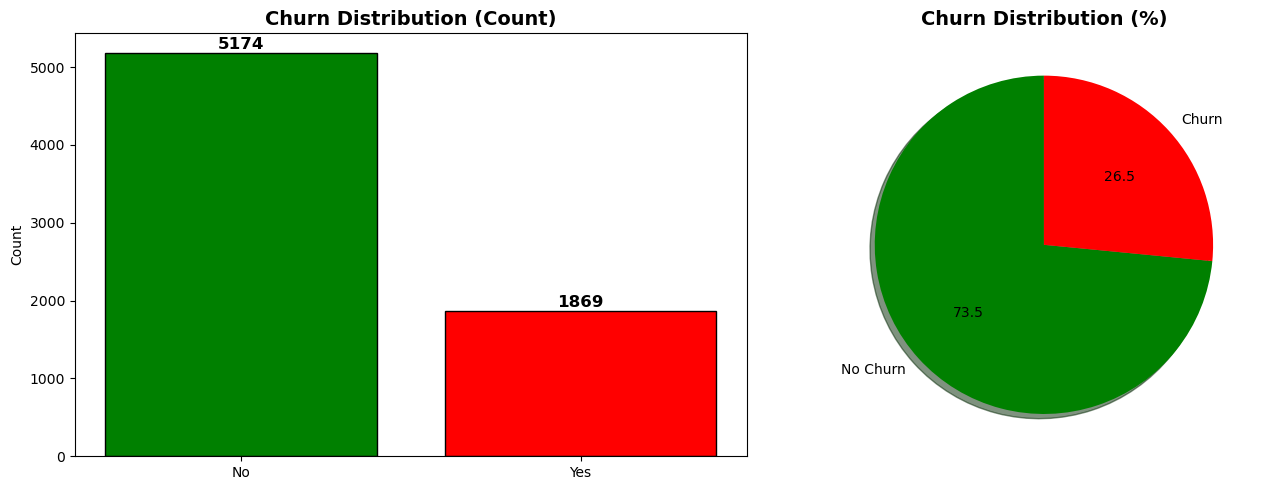


 Class Imbalance Ratio: 2.77 : 1


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
churn_counts = df['Churn'].value_counts()
colors = ['green', 'red']
axes[0].bar(churn_counts.index, churn_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Churn Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')

text_height = churn_counts.values.max() * 0.01 
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + text_height, str(v), ha='center', fontweight='bold', fontsize=12)

# Pie chart
axes[1].pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f',
            colors=colors,  shadow=True, startangle=90,
            )
axes[1].set_title('Churn Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Class Imbalance Ratio: {churn_counts.values[0]/churn_counts.values[1]:.2f} : 1")

In [7]:
# Identify column types
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns count ({len(cat_cols)}): {cat_cols}")
print(f"Numerical columns count ({len(num_cols)}): {num_cols}")

Categorical columns count (18): ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
Numerical columns count (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']


In [8]:
# cat_features = [col for col in cat_cols if col not in ['customerID', 'Churn']]

# fig, axes = plt.subplots(4, 4, figsize=(24, 20))
# axes = axes.flatten()

# for i, col in enumerate(cat_features):
#     if i < len(axes):
#         ct = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
#         ct.plot(kind='bar', stacked=True, ax=axes[i], color=['green', 'red'], edgecolor='black')
#         axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
#         axes[i].set_ylabel('Percentage')
#         axes[i].legend(['No', 'Yes'], title='Churn')
#         axes[i].tick_params(axis='x', rotation=45)

# # Hide unused subplots
# for j in range(len(cat_features), len(axes)):
#     axes[j].set_visible(False)

# plt.suptitle('Categorical Features vs Churn', fontsize=16, fontweight='bold', y=1.01)
# plt.tight_layout()
# plt.show()

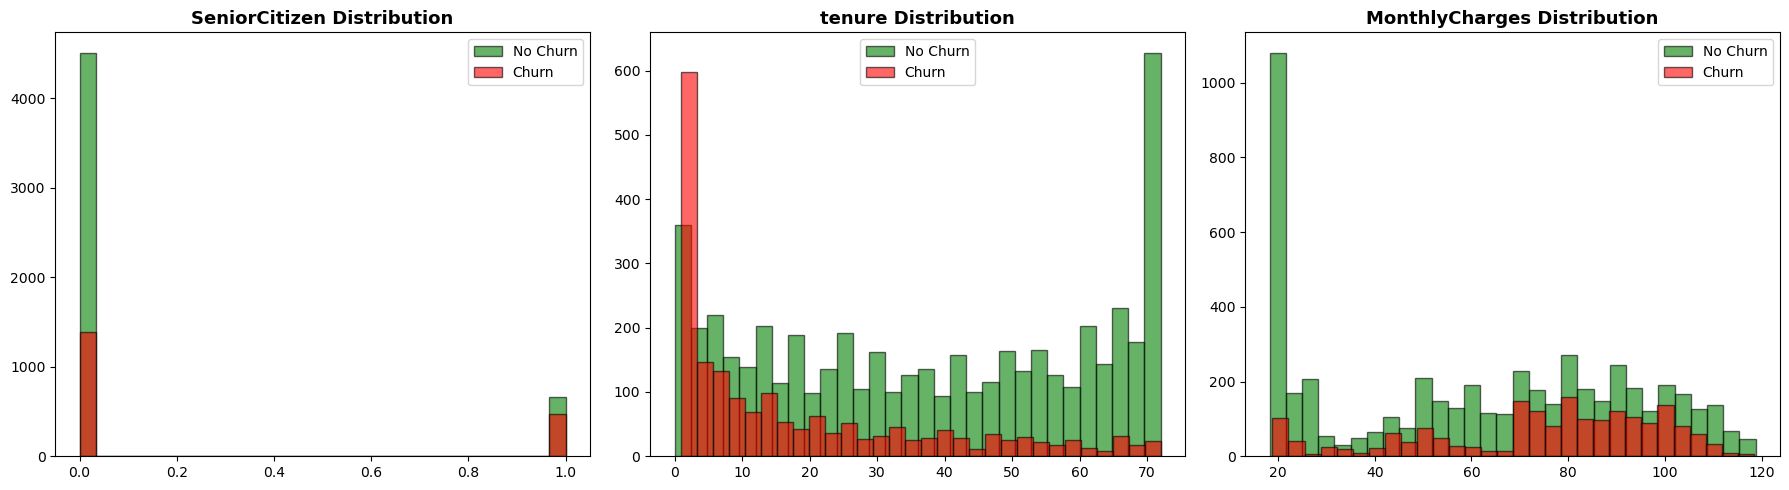

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(num_cols):
    if col != 'customerID':
        axes[i].hist(df[df['Churn'] == 'No'][col].dropna(), bins=30, alpha=0.6,
                     label='No Churn', color='green', edgecolor='black')
        axes[i].hist(df[df['Churn'] == 'Yes'][col].dropna(), bins=30, alpha=0.6,
                     label='Churn', color='red', edgecolor='black')
        axes[i].set_title(f'{col} Distribution', fontsize=13, fontweight='bold')
        axes[i].legend()

plt.tight_layout()
plt.show()

## Data Preprocessing 

In [10]:
# 1. Drop customerID (not useful for prediction)
df_clean = df.drop('customerID', axis=1)
print(f"\n 1. Dropped unused 'customerID' column")

# 2. Fix TotalCharges — has spaces that should be numeric
print(f"\n TotalCharges dtype before: {df_clean['TotalCharges'].dtype}")
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
print(f"   TotalCharges dtype after: {df_clean['TotalCharges'].dtype}")

# 3. Check missing values after conversion
missing = df_clean.isnull().sum()
print(f"\n Missing values after conversion:\n{missing[missing > 0]}")

# 4. Handle missing TotalCharges — fill with median or tenure * MonthlyCharges
# These are likely new customers with 0 tenure
print(f"\n Rows with missing TotalCharges:")
print(df_clean[df_clean['TotalCharges'].isnull()][['tenure', 'MonthlyCharges', 'TotalCharges']])

# Smart imputation: TotalCharges ≈ tenure * MonthlyCharges
mask = df_clean['TotalCharges'].isnull()
df_clean.loc[mask, 'TotalCharges'] = df_clean.loc[mask, 'tenure'] * df_clean.loc[mask, 'MonthlyCharges']

# For tenure=0 cases, fill with 0
df_clean['TotalCharges'].fillna(0, inplace=True)
print(f"\n 2. Missing TotalCharges imputed (tenure × MonthlyCharges)")

# 5. Replace 'No internet service' and 'No phone service' with 'No'
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in replace_cols:
    df_clean[col] = df_clean[col].replace('No internet service', 'No')

df_clean['MultipleLines'] = df_clean['MultipleLines'].replace('No phone service', 'No')
print(" 3. Replaced 'No internet service' / 'No phone service' → 'No'")

# 6. Remove duplicates
before = len(df_clean)
df_clean.drop_duplicates(inplace=True)
after = len(df_clean)
print(f" 4. Removed {before - after} duplicate rows")

# 7. Encode target variable
df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
print(" 5. Target variable encoded (Yes=1, No=0)")

# 8. Check SeniorCitizen is already binary (0/1)
print(f"\n 6. SeniorCitizen unique values: {df_clean['SeniorCitizen'].unique()}")

# Final check

print(f"7. Shape: {df_clean.shape}")
print(f"8. Missing values: {df_clean.isnull().sum()}")
print(f"9. Duplicates: {df_clean.duplicated().sum()}")
print(f"\n 10. Data Types:\n{df_clean.dtypes}")


 1. Dropped unused 'customerID' column

 TotalCharges dtype before: object
   TotalCharges dtype after: float64

 Missing values after conversion:
TotalCharges    11
dtype: int64

 Rows with missing TotalCharges:
      tenure  MonthlyCharges  TotalCharges
488        0           52.55           NaN
753        0           20.25           NaN
936        0           80.85           NaN
1082       0           25.75           NaN
1340       0           56.05           NaN
3331       0           19.85           NaN
3826       0           25.35           NaN
4380       0           20.00           NaN
5218       0           19.70           NaN
6670       0           73.35           NaN
6754       0           61.90           NaN

 2. Missing TotalCharges imputed (tenure × MonthlyCharges)
 3. Replaced 'No internet service' / 'No phone service' → 'No'
 4. Removed 22 duplicate rows
 5. Target variable encoded (Yes=1, No=0)

 6. SeniorCitizen unique values: [0 1]
7. Shape: (7021, 20)
8. Missing val

## Feaure Engineering

In [11]:


# 1. Create new features
df_clean['AvgMonthlyCharge'] = df_clean['TotalCharges'] / (df_clean['tenure'] + 1)
df_clean['tenure_group'] = pd.cut(df_clean['tenure'], bins=[0, 12, 24, 48, 60, 72],
                                   labels=['0-12', '13-24', '25-48', '49-60', '61-72'])
df_clean['ChargePerTenure'] = df_clean['MonthlyCharges'] / (df_clean['tenure'] + 1)

# Count total services subscribed
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_clean['TotalServices'] = df_clean[service_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)

print(" Created: AvgMonthlyCharge, tenure_group, ChargePerTenure, TotalServices")
print(f"\nUpdated shape: {df_clean.shape}")
df_clean.head()

 Created: AvgMonthlyCharge, tenure_group, ChargePerTenure, TotalServices

Updated shape: (7021, 24)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlyCharge,tenure_group,ChargePerTenure,TotalServices
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,...,Month-to-month,Yes,Electronic check,29.85,29.85,0,14.925000,0-12,14.925000,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,One year,No,Mailed check,56.95,1889.50,0,53.985714,25-48,1.627143,3
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,1,36.050000,0-12,17.950000,3
3,Male,0,No,No,45,No,No,DSL,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,0,40.016304,25-48,0.919565,3
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,1,50.550000,0-12,23.566667,1


In [12]:
# Identify final categorical columns
df_encoded = df_clean.copy()

# Label encode binary columns
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

le = LabelEncoder()
for col in binary_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# One-Hot Encode multi-class columns
multi_cols = ['InternetService', 'Contract', 'PaymentMethod', 'tenure_group']
df_encoded = pd.get_dummies(df_encoded, columns=multi_cols, drop_first=True)

print(f" Encoding complete!")
print(f"Final shape: {df_encoded.shape}")
print(f"\nAll columns:\n{df_encoded.columns.tolist()}")
df_encoded.head()

 Encoding complete!
Final shape: (7021, 31)

All columns:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn', 'AvgMonthlyCharge', 'ChargePerTenure', 'TotalServices', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure_group_13-24', 'tenure_group_25-48', 'tenure_group_49-60', 'tenure_group_61-72']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_13-24,tenure_group_25-48,tenure_group_49-60,tenure_group_61-72
0,0,0,1,0,1,0,0,0,1,0,...,False,False,False,False,True,False,False,False,False,False
1,1,0,0,0,34,1,0,1,0,1,...,False,True,False,False,False,True,False,True,False,False
2,1,0,0,0,2,1,0,1,1,0,...,False,False,False,False,False,True,False,False,False,False
3,1,0,0,0,45,0,0,1,0,1,...,False,True,False,False,False,False,False,True,False,False
4,0,0,0,0,2,1,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False


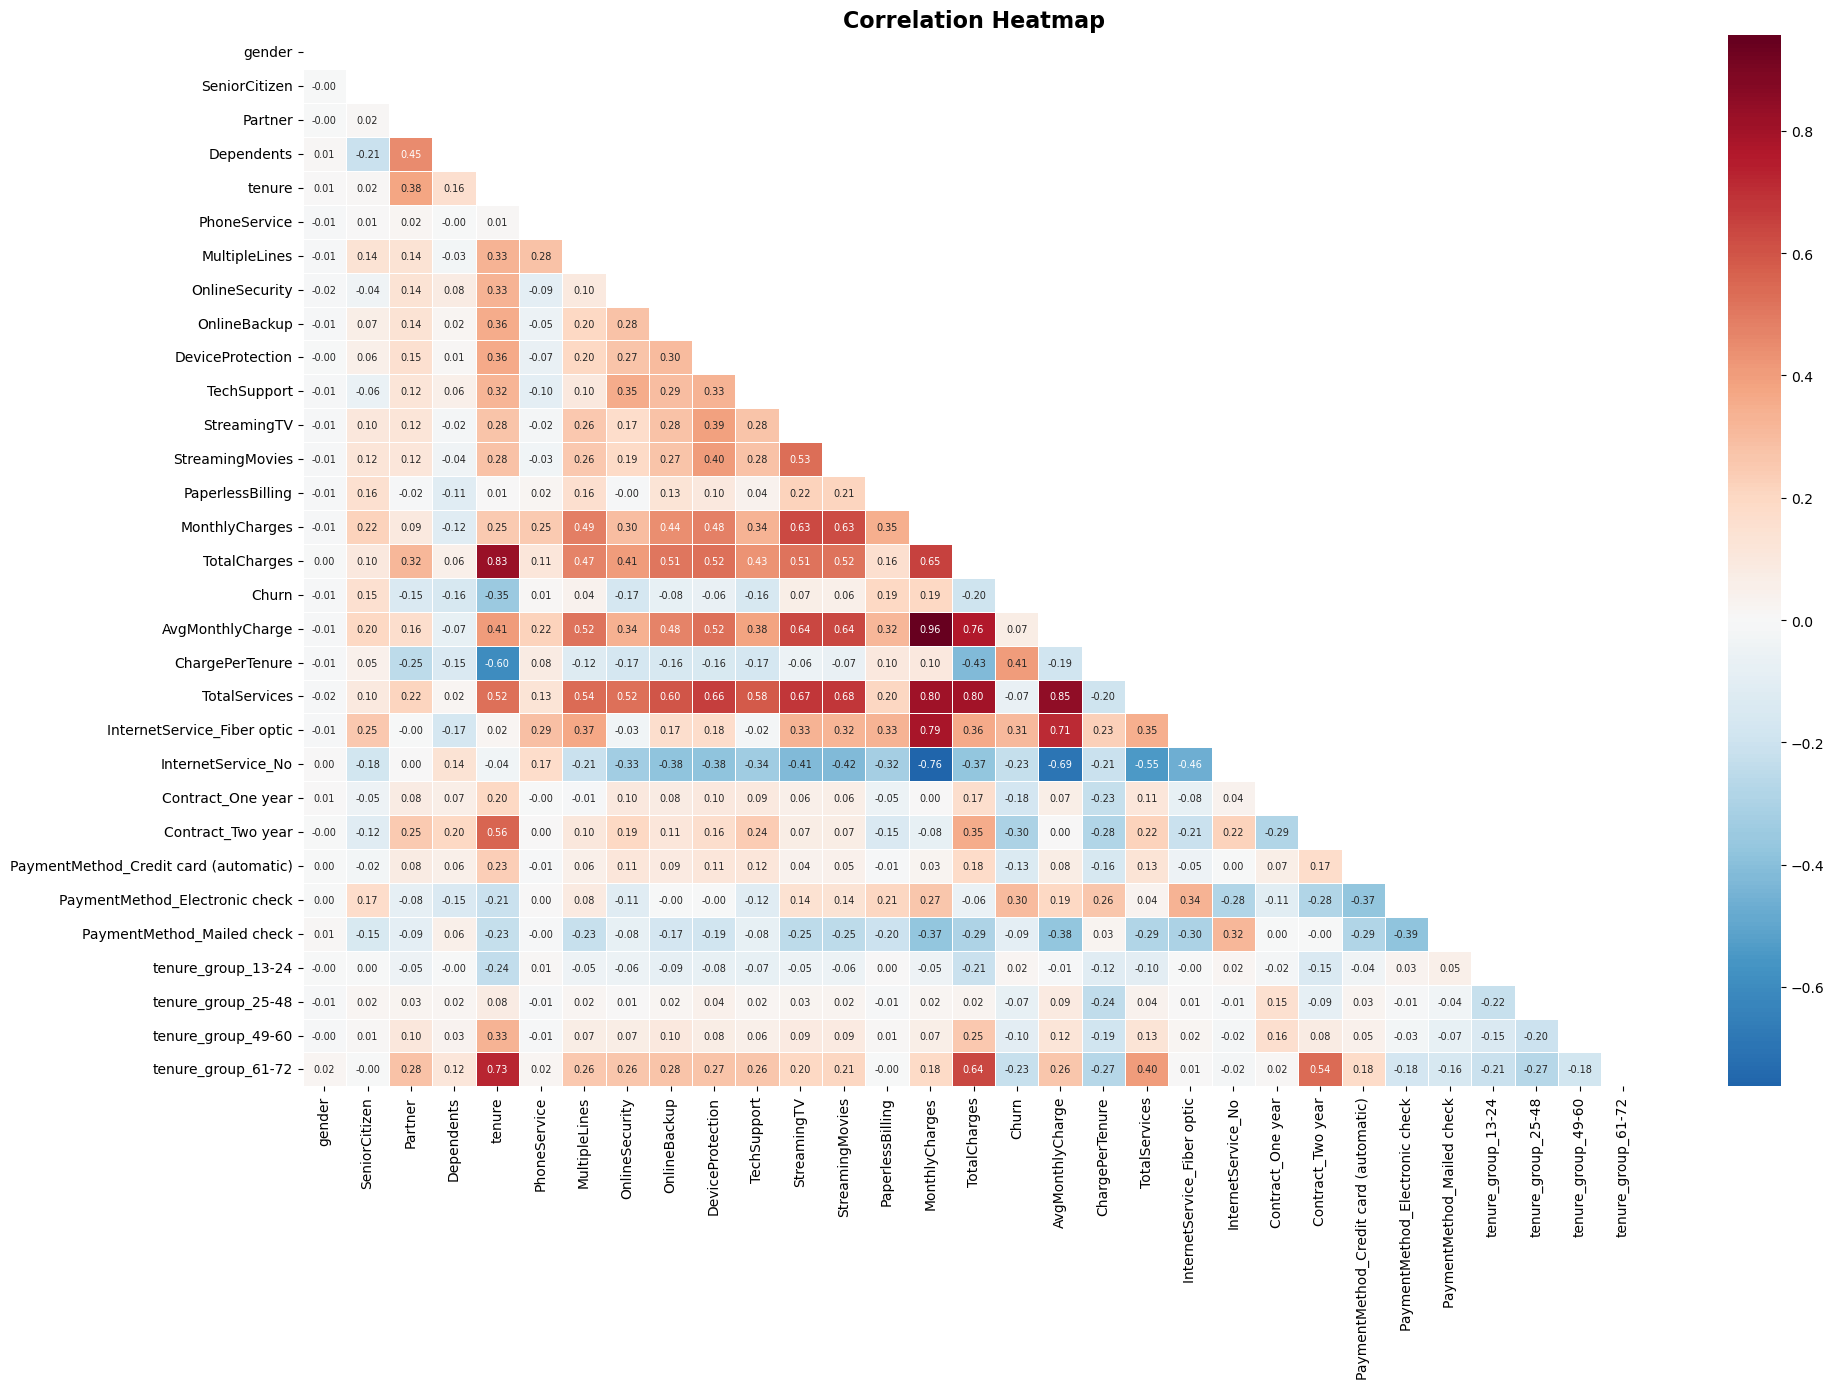


 Top Features Correlated with Churn:
ChargePerTenure                   0.409377
InternetService_Fiber optic       0.308170
PaymentMethod_Electronic check    0.301544
MonthlyCharges                    0.194508
PaperlessBilling                  0.190891
SeniorCitizen                     0.151619
AvgMonthlyCharge                  0.074830
StreamingTV                       0.065032
StreamingMovies                   0.063192
MultipleLines                     0.041958
Name: Churn, dtype: float64

 tenure               -0.351508
Contract_Two year    -0.302076
InternetService_No   -0.228533
tenure_group_61-72   -0.225185
TotalCharges         -0.197198
Contract_One year    -0.177336
OnlineSecurity       -0.170520
TechSupport          -0.163937
Dependents           -0.163459
Partner              -0.149135
Name: Churn, dtype: float64


In [13]:
plt.figure(figsize=(20, 14))
corr = df_encoded.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, linewidths=0.5, annot_kws={'size': 7})
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with Churn
print("\n Top Features Correlated with Churn:")
print(corr['Churn'].drop('Churn').sort_values(ascending=False).head(10))
print("\n", corr['Churn'].drop('Churn').sort_values().head(10))

In [14]:
# Separate features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set:     {X_test.shape}")
print(f"\nTarget distribution (Train):\n{y_train.value_counts(normalize=True).round(3)}")
print(f"\nTarget distribution (Test):\n{y_test.value_counts(normalize=True).round(3)}")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print("\n StandardScaler applied!")

Training set: (5616, 30)
Test set:     (1405, 30)

Target distribution (Train):
Churn
0    0.736
1    0.264
Name: proportion, dtype: float64

Target distribution (Test):
Churn
0    0.735
1    0.265
Name: proportion, dtype: float64

 StandardScaler applied!


In [15]:
# Define all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, verbosity=0),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(random_state=42, algorithm='SAMME')
}

# Train and evaluate each model
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=" * 90)
print(f"{'Model':<25} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'ROC-AUC':>10}")
print("=" * 90)

for name, model in models.items():
    # Fit
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc,
        'CV_F1_Mean': cv_scores.mean(),
        'CV_F1_Std': cv_scores.std()
    })

    print(f"{name:<25} {acc:>10.4f} {prec:>10.4f} {rec:>10.4f} {f1:>10.4f} {roc:>10.4f}")

print("=" * 90)

# Results DataFrame
results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False).reset_index(drop=True)
results_df

Model                       Accuracy  Precision     Recall   F1-Score    ROC-AUC
Logistic Regression           0.8043     0.6726     0.5081     0.5789     0.8418
Decision Tree                 0.7388     0.5066     0.5188     0.5126     0.6701
Random Forest                 0.7794     0.6157     0.4435     0.5156     0.8195
Gradient Boosting             0.8014     0.6587     0.5188     0.5805     0.8404
XGBoost                       0.7815     0.6066     0.4973     0.5465     0.8309
LightGBM                      0.7929     0.6355     0.5108     0.5663     0.8357
KNN                           0.7559     0.5466     0.4570     0.4978     0.7652
SVM                           0.7943     0.6578     0.4651     0.5449     0.7846
Naive Bayes                   0.7537     0.5245     0.7473     0.6164     0.8295
AdaBoost                      0.7986     0.6508     0.5161     0.5757     0.8286


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,CV_F1_Mean,CV_F1_Std
0,Naive Bayes,0.753737,0.524528,0.747312,0.616408,0.829472,0.625844,0.017759
1,Gradient Boosting,0.801423,0.658703,0.518817,0.580451,0.840376,0.580690,0.025957
2,Logistic Regression,0.804270,0.672598,0.508065,0.578867,0.841776,0.588014,0.034549
3,AdaBoost,0.798577,0.650847,0.516129,0.575712,0.828604,0.575538,0.023070
4,LightGBM,0.792883,0.635452,0.510753,0.566319,0.835675,0.570805,0.021712
5,XGBoost,0.781495,0.606557,0.497312,0.546529,0.830930,0.564869,0.022979
6,SVM,0.794306,0.657795,0.465054,0.544882,0.784599,0.570027,0.030752
7,Random Forest,0.779359,0.615672,0.443548,0.515625,0.819468,0.538669,0.021930
8,Decision Tree,0.738790,0.506562,0.518817,0.512616,0.670145,0.485399,0.014517
9,KNN,0.755872,0.546624,0.456989,0.497804,0.765200,0.546844,0.019761


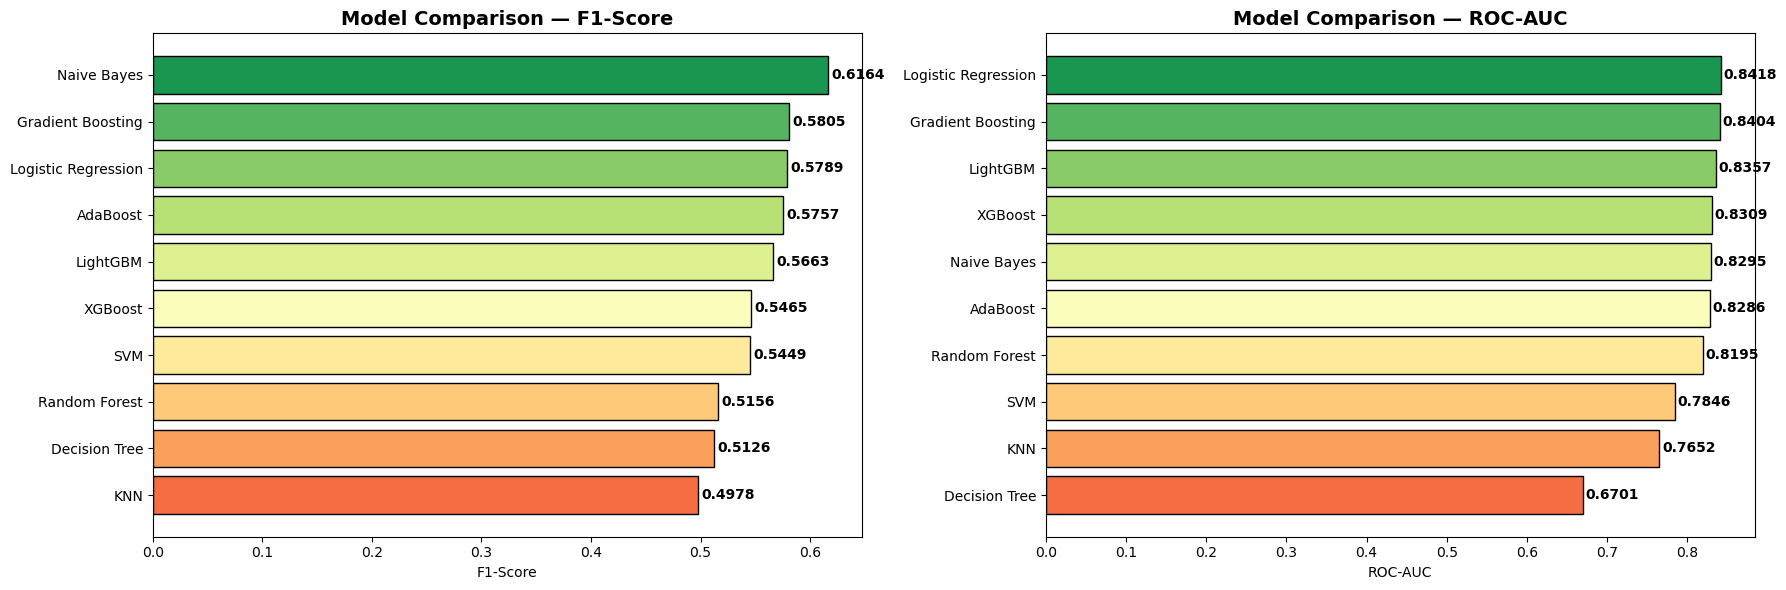

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1-Score comparison
results_sorted = results_df.sort_values('F1-Score', ascending=True)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(results_sorted)))
axes[0].barh(results_sorted['Model'], results_sorted['F1-Score'], color=colors, edgecolor='black')
axes[0].set_xlabel('F1-Score')
axes[0].set_title('Model Comparison — F1-Score', fontsize=14, fontweight='bold')
for i, v in enumerate(results_sorted['F1-Score']):
    axes[0].text(v + 0.003, i, f'{v:.4f}', va='center', fontweight='bold')

# ROC-AUC comparison
results_sorted2 = results_df.sort_values('ROC-AUC', ascending=True)
axes[1].barh(results_sorted2['Model'], results_sorted2['ROC-AUC'], color=colors, edgecolor='black')
axes[1].set_xlabel('ROC-AUC')
axes[1].set_title('Model Comparison — ROC-AUC', fontsize=14, fontweight='bold')
for i, v in enumerate(results_sorted2['ROC-AUC']):
    axes[1].text(v + 0.003, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
# Select top 3 models based on F1-Score
top3 = results_df.head(3)['Model'].tolist()
print(f" Top 3 Models for Tuning: {top3}\n")

# Define hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 0.1, 1]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [20, 31, 50],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
    }
}

# Model objects mapping
model_objects = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, verbosity=0),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(random_state=42, algorithm='SAMME')
}

# Hyperparameter tuning for top 3
tuned_models = {}
tuning_results = []

for model_name in top3:
    print(f"\n{'='*60}")
    print(f" Tuning: {model_name}")
    print(f"{'='*60}")

    grid_search = RandomizedSearchCV(
        estimator=model_objects[model_name],
        param_distributions=param_grids[model_name],
        n_iter=50,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train_scaled, y_train)

    # Best params & score
    print(f"   Best Params: {grid_search.best_params_}")
    print(f"   Best CV F1:  {grid_search.best_score_:.4f}")

    # Evaluate on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    print(f"   Test Accuracy: {acc:.4f}")
    print(f"   Test F1-Score: {f1:.4f}")
    print(f"   Test ROC-AUC:  {roc:.4f}")

    tuned_models[model_name] = best_model
    tuning_results.append({
        'Model': model_name,
        'Best_CV_F1': grid_search.best_score_,
        'Test_Accuracy': acc,
        'Test_F1': f1,
        'Test_ROC_AUC': roc,
        'Best_Params': grid_search.best_params_
    })

tuning_df = pd.DataFrame(tuning_results).sort_values('Test_F1', ascending=False)

tuning_df[['Model', 'Best_CV_F1', 'Test_Accuracy', 'Test_F1', 'Test_ROC_AUC']]

 Top 3 Models for Tuning: ['Naive Bayes', 'Gradient Boosting', 'Logistic Regression']


 Tuning: Naive Bayes
   Best Params: {'var_smoothing': 1e-09}
   Best CV F1:  0.6258
   Test Accuracy: 0.7537
   Test F1-Score: 0.6164
   Test ROC-AUC:  0.8295

 Tuning: Gradient Boosting
   Best Params: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 3, 'learning_rate': 0.1}
   Best CV F1:  0.5861
   Test Accuracy: 0.7986
   Test F1-Score: 0.5719
   Test ROC-AUC:  0.8401

 Tuning: Logistic Regression
   Best Params: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.01}
   Best CV F1:  0.5991
   Test Accuracy: 0.8085
   Test F1-Score: 0.5893
   Test ROC-AUC:  0.8412


 TUNING RESULTS SUMMARY


,Model,Best_CV_F1,Test_Accuracy,Test_F1,Test_ROC_AUC
0,Naive Bayes,0.625844,0.753737,0.616408,0.829472
2,Logistic Regression,0.599139,0.808541,0.589313,0.841238
1,Gradient Boosting,0.586077,0.798577,0.571861,0.840091


In [18]:
# Select the BEST model
best_model_name = tuning_df.iloc[0]['Model']
best_model = tuned_models[best_model_name]

print(f" BEST MODEL: {best_model_name}")
print(f"   Best Params: {tuning_df.iloc[0]['Best_Params']}")
print(f"   Test F1-Score: {tuning_df.iloc[0]['Test_F1']:.4f}")
print(f"   Test ROC-AUC: {tuning_df.iloc[0]['Test_ROC_AUC']:.4f}")

# Final predictions
y_pred_final = best_model.predict(X_test_scaled)
y_prob_final = best_model.predict_proba(X_test_scaled)[:, 1]

 BEST MODEL: Naive Bayes
   Best Params: {'var_smoothing': 1e-09}
   Test F1-Score: 0.6164
   Test ROC-AUC: 0.8295


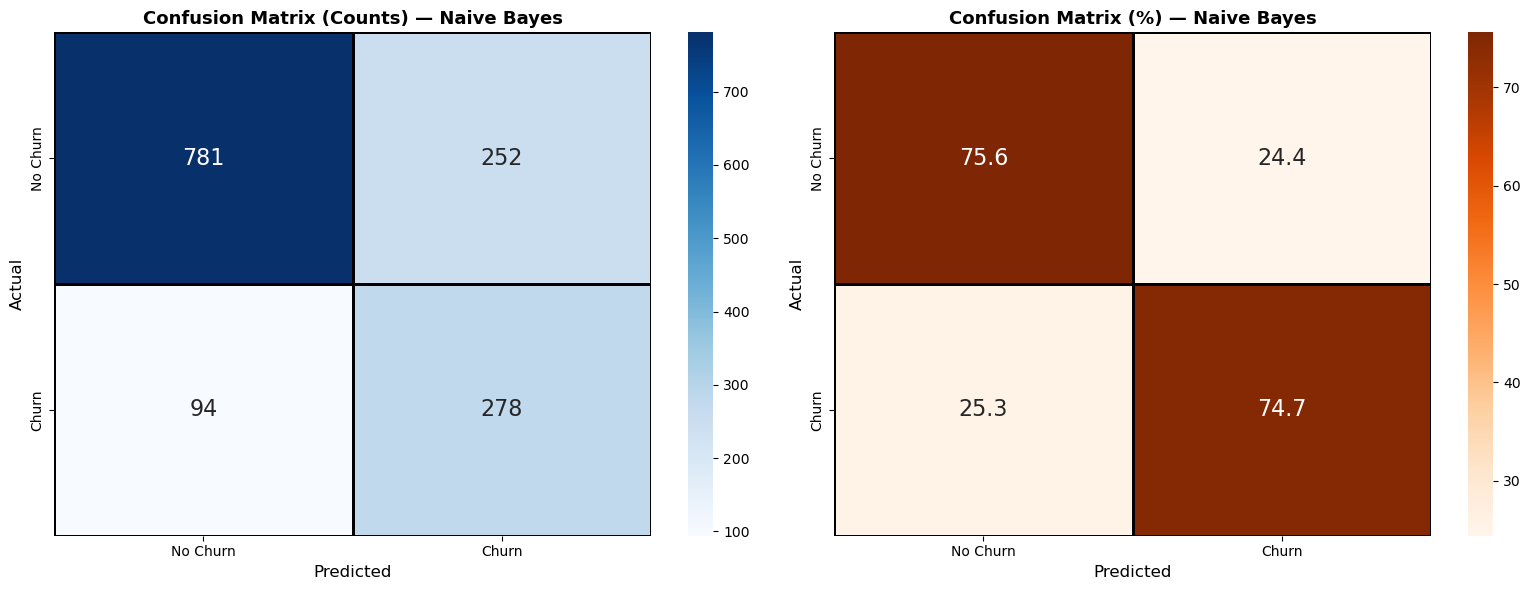

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix - Counts
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'], ax=axes[0], annot_kws={'size': 16},
            linewidths=2, linecolor='black')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(f'Confusion Matrix (Counts) — {best_model_name}', fontsize=13, fontweight='bold')

# Confusion Matrix - Percentages
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Oranges', xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'], ax=axes[1], annot_kws={'size': 16},
            linewidths=2, linecolor='black')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'Confusion Matrix (%) — {best_model_name}', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

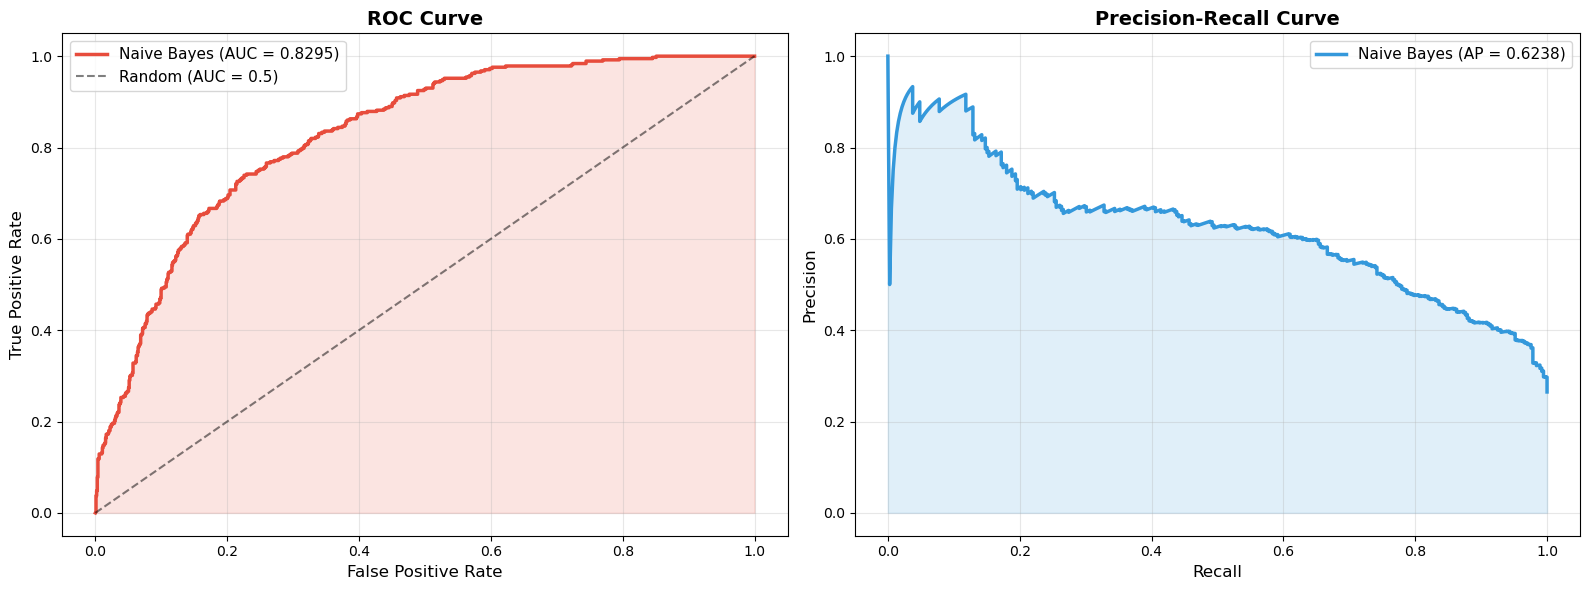

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ---- ROC Curve ----
fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob_final)
roc_auc = roc_auc_score(y_test, y_prob_final)

axes[0].plot(fpr, tpr, color='#e74c3c', linewidth=2.5, label=f'{best_model_name} (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random (AUC = 0.5)')
axes[0].fill_between(fpr, tpr, alpha=0.15, color='#e74c3c')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# ---- Precision-Recall Curve ----
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_prob_final)
avg_prec = average_precision_score(y_test, y_prob_final)

axes[1].plot(recall_vals, precision_vals, color='#3498db', linewidth=2.5,
             label=f'{best_model_name} (AP = {avg_prec:.4f})')
axes[1].fill_between(recall_vals, precision_vals, alpha=0.15, color='#3498db')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

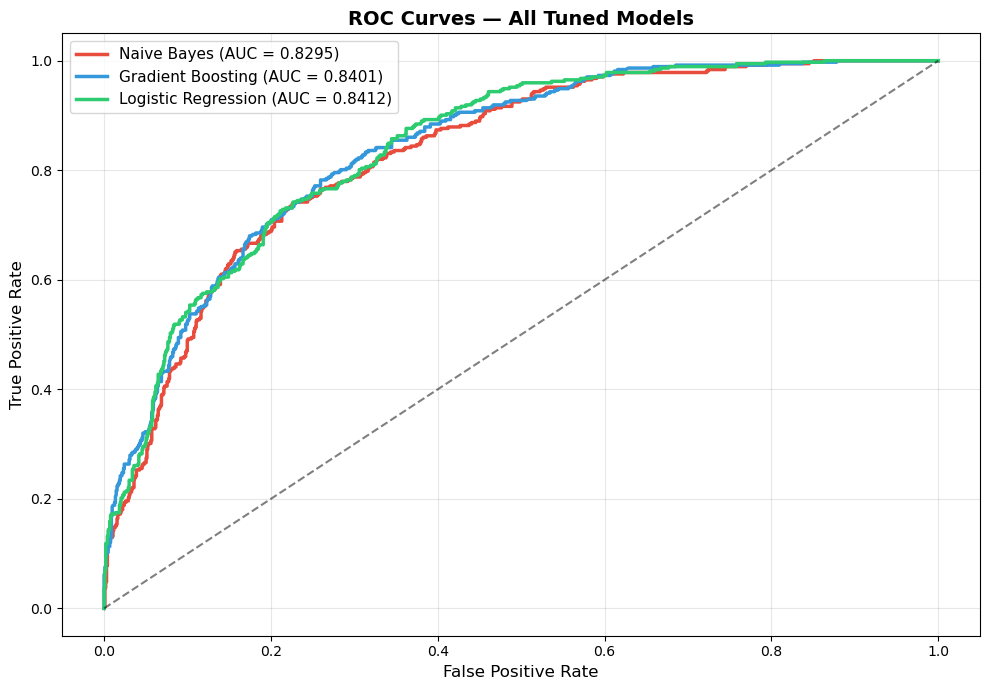

In [21]:
plt.figure(figsize=(10, 7))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
for i, (name, model) in enumerate(tuned_models.items()):
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], linewidth=2.5,
             label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves — All Tuned Models', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Feature importance (if tree-based model)
try:
    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=True).tail(15)

    plt.figure(figsize=(10, 8))
    plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='#3498db', edgecolor='black')
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 15 Feature Importances — {best_model_name}', fontsize=14, fontweight='bold')
    for i, v in enumerate(feat_imp['Importance']):
        plt.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()
except AttributeError:
    # For models without feature_importances_ (like LR), use coefficients
    if hasattr(best_model, 'coef_'):
        coefs = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': np.abs(best_model.coef_[0])
        }).sort_values('Coefficient', ascending=True).tail(15)

        plt.figure(figsize=(10, 8))
        plt.barh(coefs['Feature'], coefs['Coefficient'], color='#e74c3c', edgecolor='black')
        plt.xlabel('|Coefficient|', fontsize=12)
        plt.title(f'Top 15 Feature Importances — {best_model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

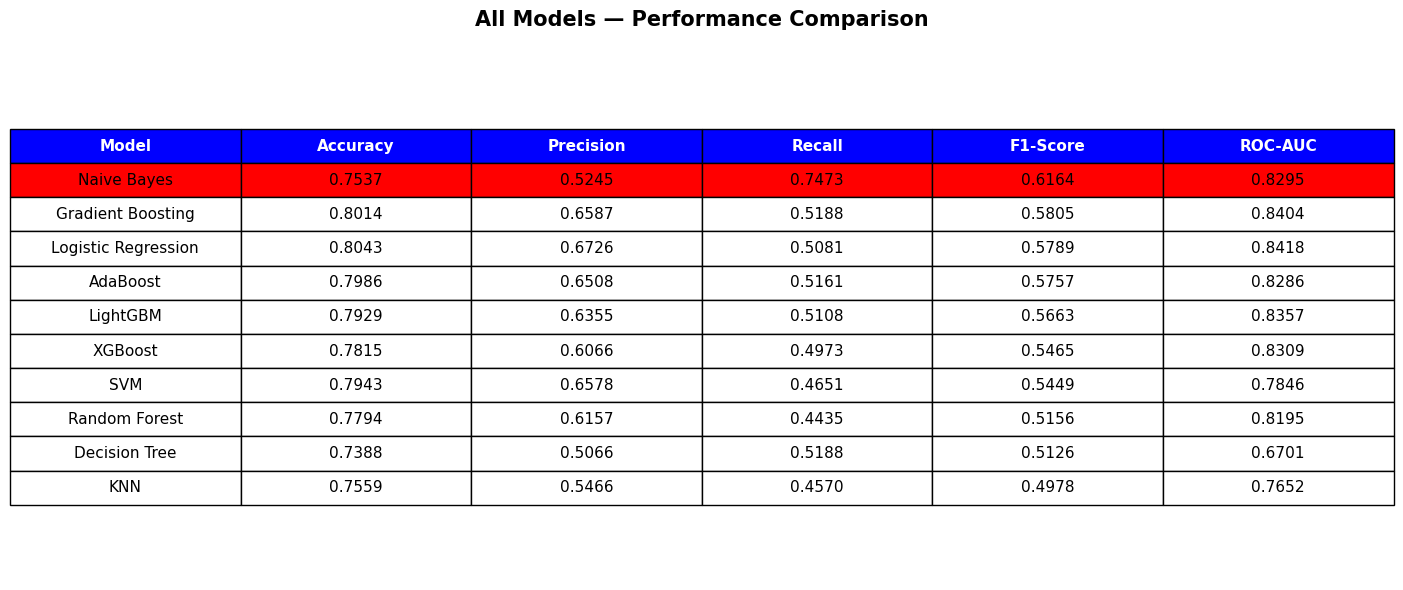

In [23]:


# Final comparison table — all models
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('off')

table_data = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].values
col_labels = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

table = ax.table(cellText=np.round(table_data, 4) if False else
                 [[row[0]] + [f'{v:.4f}' for v in row[1:]] for row in table_data],
                 colLabels=col_labels, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Highlight header
for j in range(len(col_labels)):
    table[0, j].set_facecolor('blue')
    table[0, j].set_text_props(color='white', fontweight='bold')

# Highlight best model row
for j in range(len(col_labels)):
    table[1, j].set_facecolor('red')

plt.title('All Models — Performance Comparison', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

